In [1]:
from typing import *
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, transpile
sim = AerSimulator()

from util import zero, one, Z

# QC: Grover's Search

**Under Construction**

In this notebook, we'll introduce **Grover's search**. It enables us to search an unstructured dataset of length $N$ in time $O(\sqrt{N})$, which provides a quadratic speedup compared to a classical algorithm which takes $O(N)$ time.

References
1. [Introduction to Classical and Quantum Computing: Chapter 7.6](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [Qiskit notebook on Grover's search](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb)

## Problem: Unstructured Search

The problem of unstructured search involves searching a database, i.e., set of all bit strings $\{0, 1\}^n$ over $n$ bits for a particular bit string $w$, called the **marked bitstring**. Intuitively, a classical algorithm would take $O(N)$ time where $N = 2^n$ since we must check every part of the database.

In [2]:
n = 3
N = 2**n
marked_bitstring = "010"
database = set([format(i, f"0{n}b") for i in range(2**n)])
database

{'000', '001', '010', '011', '100', '101', '110', '111'}

### Reforumulation: Query

We can reformulate this as a query problem. In particular, define a function $f_w: \{ 0, 1 \}^n \rightarrow \{0, 1\}$ such that $f_w(x) = 1$ iff $x = w$ and $0$ otherwise. Then $f_w$ can be put into one-to-one correspondence with databases $\{0, 1\}^n$ with a marked string w.

In [3]:
def f_w(x) -> bool:
    return marked_string == x

## Algorithm Walkthrough

We'll now walkthrough Grover's search algortihm. 

In [4]:
marked_qubit = zero ^ one ^ zero
marked_qubit.draw("latex")

<IPython.core.display.Latex object>

### Step 1: Put first n qubits in superposition

Our first step is to put the $n$ qubits in superposition. As usual, we will accomplish this by applying Hadamard gates to all qubits.

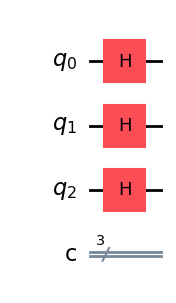

In [5]:
qc = QuantumCircuit(n, n)
qc.h(range(n))
qc.draw(output="mpl", style="iqp")

#### State after step 1

After the application of the H gates, we have the following state

$$
|s\rangle = H^{\otimes n} |0\rangle^{\otimes n} = |+\rangle^{\otimes n} \,.
$$

In [6]:
s1 = (zero ^ zero ^ zero).evolve(Operator(qc))
s1.draw("latex")

<IPython.core.display.Latex object>

### State Representation

For Grover's search, it is conveneient to consider a representation of the intermediate quantum states as a linear combination of $|w\rangle$ and the states orthogonal to $|w\rangle$. We can rewrite the state above as

\begin{align*}
|s\rangle & = \frac{1}{\sqrt{N}} |w\rangle + \frac{1}{\sqrt{N}} \sum_{i \neq w} |i\rangle \tag{factor} \\
&= \frac{1}{\sqrt{N}} |w\rangle + \frac{\sqrt{N-1}}{\sqrt{N}} \underbrace{\frac{1}{\sqrt{N - 1}} \sum_{i \neq w} |i\rangle}_{|r\rangle} \tag{rearrange} \\
&= \frac{1}{\sqrt{N}} |w\rangle + \sqrt{\frac{N-1}{N}} |r\rangle \tag{substitute $|r\rangle$} \\
&= \sin \theta |w\rangle + \cos \theta |r\rangle \tag{$sin^2\theta + \cos^2 \theta = 1$}
\end{align*}

where
1. $|r\rangle = \frac{1}{\sqrt{N - 1}} \sum_{i \neq w} |i\rangle$,
2. $\sin \theta = \frac{1}{\sqrt{N}}$, and
3. $\cos \theta = \frac{\sqrt{N-1}}{\sqrt{N}}$.

Implicilty, $|w\rangle$ uses the binary representation of $w$, i.e., $|w\rangle = |\overline{w}\rangle$. We do this for notational simplicity.

#### Visualization

This state representation enables us to construct two helpful visualizations for seeing the quantum state as it evolve through Grover's algorithm:
1. a **angle** visualization and
2. a **amplitude and phase** visualization.

##### Angle Visualization

We can visualize the angle between the current state $|s\rangle$ and the marked state $|w\rangle$. The smaller the angle, the more likely a measurement will collapse to the state $|w\rangle$, our solution state.

In [7]:
def plot_angle(ax, marked_qubit: Statevector, s: Statevector) -> None:
    theta = np.arccos(np.dot(s, marked_qubit).real / np.sqrt(N) * np.sqrt(N-1))
    ax.set_xlim(-.1, 1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect("equal")
    ax.quiver(0, 0, np.sin(theta), np.cos(theta), angles='xy', scale_units='xy', scale=1, color='green', label=r'$|w\rangle$')
    ax.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='red', label=r'$|w\rangle$')
    ax.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='blue', label=r'$|r\rangle$')
    ax.legend()

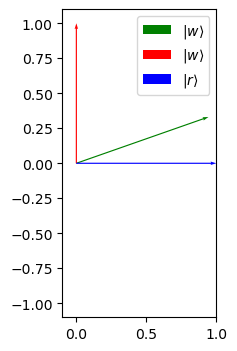

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_angle(ax, marked_qubit, s1)

##### Amplitude and Phase Visualization

We introduce a visualization the tracks the "probability" amplitudes of the quantum state as Grover's search is applied. The larger the magnitude of the probability amplitude, the more likely a measurement will collapse the current state to $|w\rangle$, our solution state. The marked state that we are searching for is given in red. Every other state is given in blue.

In [9]:
def plot_amplitudes(ax, marked_state: str, s: Statevector) -> None:
    real_amps = [s.data[i].real for i in range(len(s))]
    N = len(real_amps)
    x_axis = np.arange(0, N, 1)
    colors = ["blue"] * N
    colors[int(marked_state, 2)] = "red"
    n = int(math.log2(N))
    axis_labels = [format(i, f"0{n}b") for i in range(2**n)]
    ax.grid()
    ax.bar(x_axis, real_amps, width=0.25, tick_label=axis_labels, color=colors)
    ax.set_ylim(-1, 1)

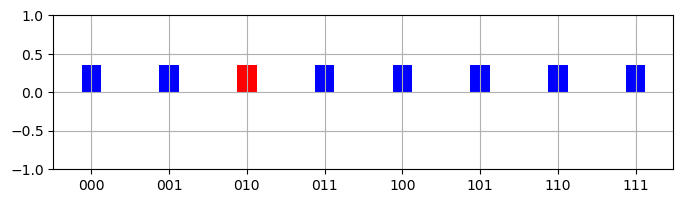

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
plot_amplitudes(ax, marked_bitstring, s1)

##### Plotting together

We can put both plots side by side.

In [11]:
def plot_angles_and_amplitudes(marked_state: str, marked_qubit: Statevector, s: Statevector) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plot_angle(axs[0], marked_qubit, s)
    plot_amplitudes(axs[1], marked_bitstring, s)

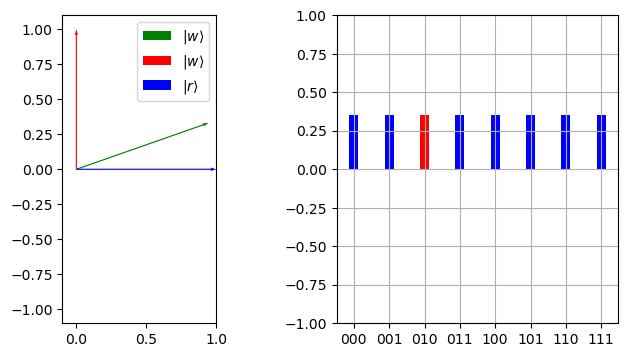

In [12]:
plot_angles_and_amplitudes(marked_bitstring, marked_qubit, s1)

### Step 2: Iterative Amplification

We will iteratively apply the following two steps:
1. **Grover's oracle** and
2. **Grover's diffuser**.

#### Step 2.1: Apply Oracle

We define an oracle $U_f$ that flips the phase of the marked state.

$$
U_f |x\rangle = \begin{cases}
-|w\rangle & \mbox{$x = w$} \\
-|x\rangle & \mbox{otherwise} \,.
\end{cases}
$$

Towards this end, we will use the binary representation of $|w\rangle$ as control bits to a circuit that will flip the phase

##### Aside: Multi-Controlled Z Gate (MCZ)

The $MCZ$ gate is a gate that flips the target qubit's phase if all the control qubits are set and does nothing otherwise. Unfortunately, Qiskit does not provide a MCZ gate so we will need to build one from scratch.

First, we can construct a Z Gate from X and H.

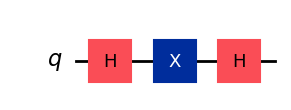

In [13]:
qc_z = QuantumCircuit(1)
qc_z.h(0)
qc_z.x(0)
qc_z.h(0)
qc_z.draw(output="mpl", style="iqp")

In [14]:
np.allclose(Operator(qc_z), Z)

True

Second, we do have access to a MCX gate, i.e., a multi-controlled X gate. This applies a X gate to a target qubit if all control qubits are set.

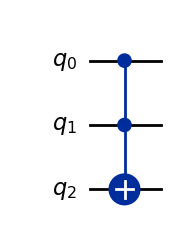

In [15]:
qc_mcx = QuantumCircuit(3)
qc_mcx.mcx([0, 1], 2)   # controls, target
qc_mcx.draw(output="mpl", style="iqp")

In [16]:
# MCX|011> = |111>
(zero ^ one ^ one).evolve(Operator(qc_mcx)).draw("latex")

<IPython.core.display.Latex object>

Finally, we can put this together.

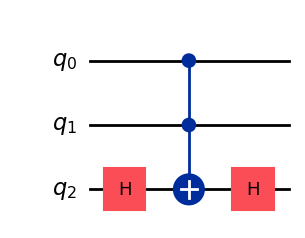

In [18]:
qc_mcz = QuantumCircuit(3)
qc_mcz.h(2)
qc_mcz.mcx([0, 1], 2)   # controls, target
qc_mcz.h(2)
qc_mcz.draw(output="mpl", style="iqp")

In [19]:
Operator(qc_mcz).draw("latex")

<IPython.core.display.Latex object>

In [20]:
# MCZ|111> = -|111>
(one ^ one ^ one).evolve(Operator(qc_mcz)).draw("latex")

<IPython.core.display.Latex object>

##### Grover's oracle from MCZ

The MCZ gate flipped the phase of the state $|111\rangle$. In order to flip the phase of the marked state, we need to map it to the state $|111\rangle$ and then "undo" our mapping which is possible since quantum operations are reversible. Towards this end, we observe that if a marked state contains a $0$ we should apply an X gate to set it. For our target qubit, if it is $0$ then the $X$ gate will flip it to $1$ and if it is $1$, then it already has the correct bit set.

In [21]:
def grover_oracle(qc, marked_state):    
    n_qubits = qc.num_qubits
    # Apply X gates to qubits that should be |0⟩ in the marked state
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    
    # ---- MCZ -----
    qc.h(n_qubits - 1)  # Change the target qubit to the |-| state
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled X with n-1 controls
    qc.h(n_qubits - 1)  # Undo the |-| state
    # ---- MCZ -----
    
    # Apply X gates again to revert the qubits to their original state
    for i, bit in enumerate(marked_state):
        if bit == '0':
            qc.x(i)

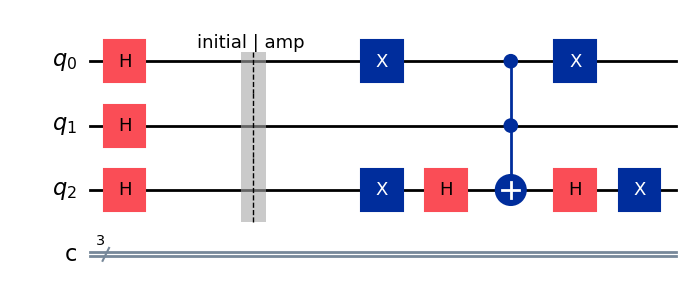

In [22]:
qc.barrier(label="initial | amp ")
grover_oracle(qc, marked_bitstring)
qc.draw(output="mpl", style="iqp")

In [25]:
s2_1 = (zero ^ zero ^ zero).evolve(Operator(qc))
s2_1.draw("latex")

<IPython.core.display.Latex object>

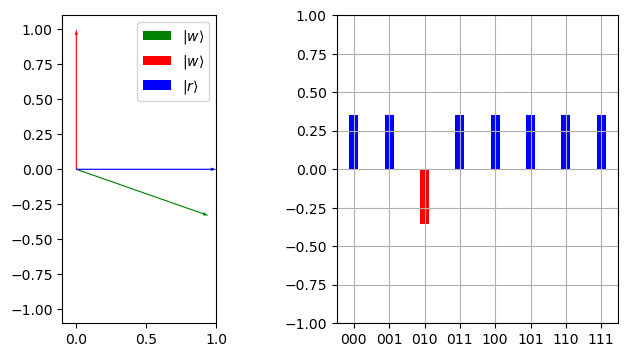

In [26]:
plot_angles_and_amplitudes(marked_bitstring, marked_qubit, s2_1)

#### Step 2.2: Diffuser

We now would like to boost the probability of the marked state somehow. This should be possible since we have flipped its phase so it is somehow distinguished from the other states. We accomplish this with the following operator

$$
R_w = 2|w\rangle\langle w| - I \,.
$$

This leaves $|w\rangle$ alone

\begin{align*}
R_w |w\rangle & = (2|w\rangle\langle w| - I)|w\rangle \\
& = 2|w\rangle\langle w|w\rangle - |w\rangle \\
& = 2|w\rangle - |w\rangle \\
& = |w\rangle \,.
\end{align*}

Additionally, it flips the phase of any state vector orthogonal to $|w\rangle$ as in

\begin{align*}
R_w |w^\perp\rangle & = (2|w\rangle\langle w| - I)||w^\perp\rangle \\
& = 2|w\rangle\langle w|w^\perp\rangle - |w^\perp\rangle \\
& = -|w^\perp\rangle \,.
\end{align*}

In [27]:
def grover_diffuser(qc):    
    n_qubits = qc.num_qubits
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    
    # ---- MCZ -----
    qc.h(n_qubits - 1)  # Change the target qubit to the |-| state
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled X with n-1 controls
    qc.h(n_qubits - 1)  # Undo the |-| state
    # ---- MCZ -----
    
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    
    return qc

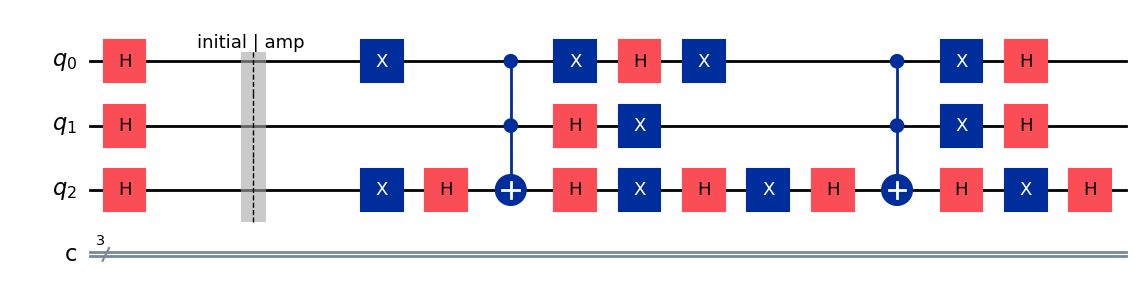

In [28]:
grover_diffuser(qc)
qc.draw(output="mpl", style="iqp")

In [29]:
s2_2 = (zero ^ zero ^ zero).evolve(Operator(qc))
s2_2.draw("latex")

<IPython.core.display.Latex object>

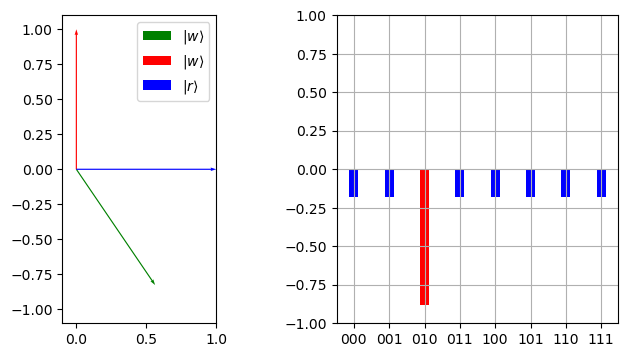

In [30]:
plot_angles_and_amplitudes(marked_bitstring, marked_qubit, s2_2)

#### How many iterations?

We see geometrically that each iteration of applying Grover's oracle and diffuser doubles the angle of $|s\rangle$ from $|r\rangle$. Consequently, after iteration, we should get closer and closer to the solution state at an increasing rate. After some algebra, we see that the optimal number of iterations is

$$
\frac{\pi}{4}\sqrt{N} \,.
$$

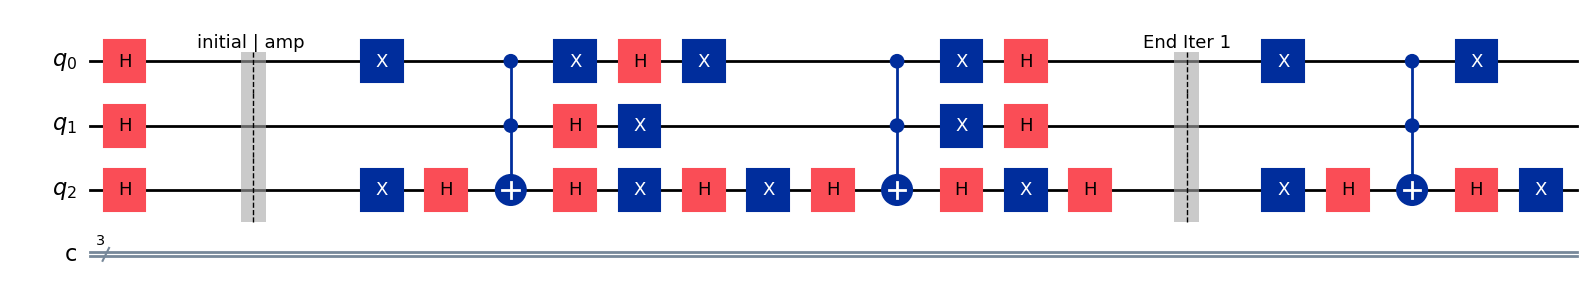

In [31]:
qc.barrier(label=f"End Iter {1}")
grover_oracle(qc, marked_bitstring)
qc.draw(output="mpl", style="iqp")

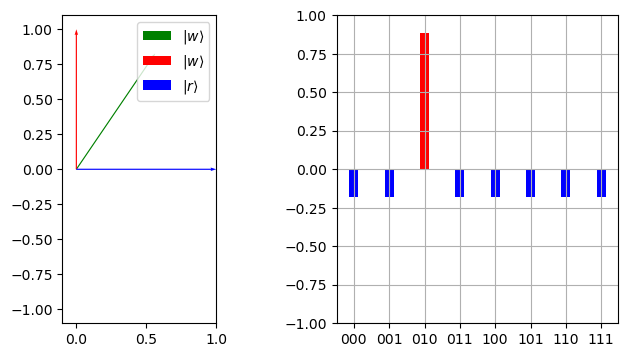

In [32]:
s2_iter2_1 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_angles_and_amplitudes(marked_bitstring, marked_qubit, s2_iter2_1)

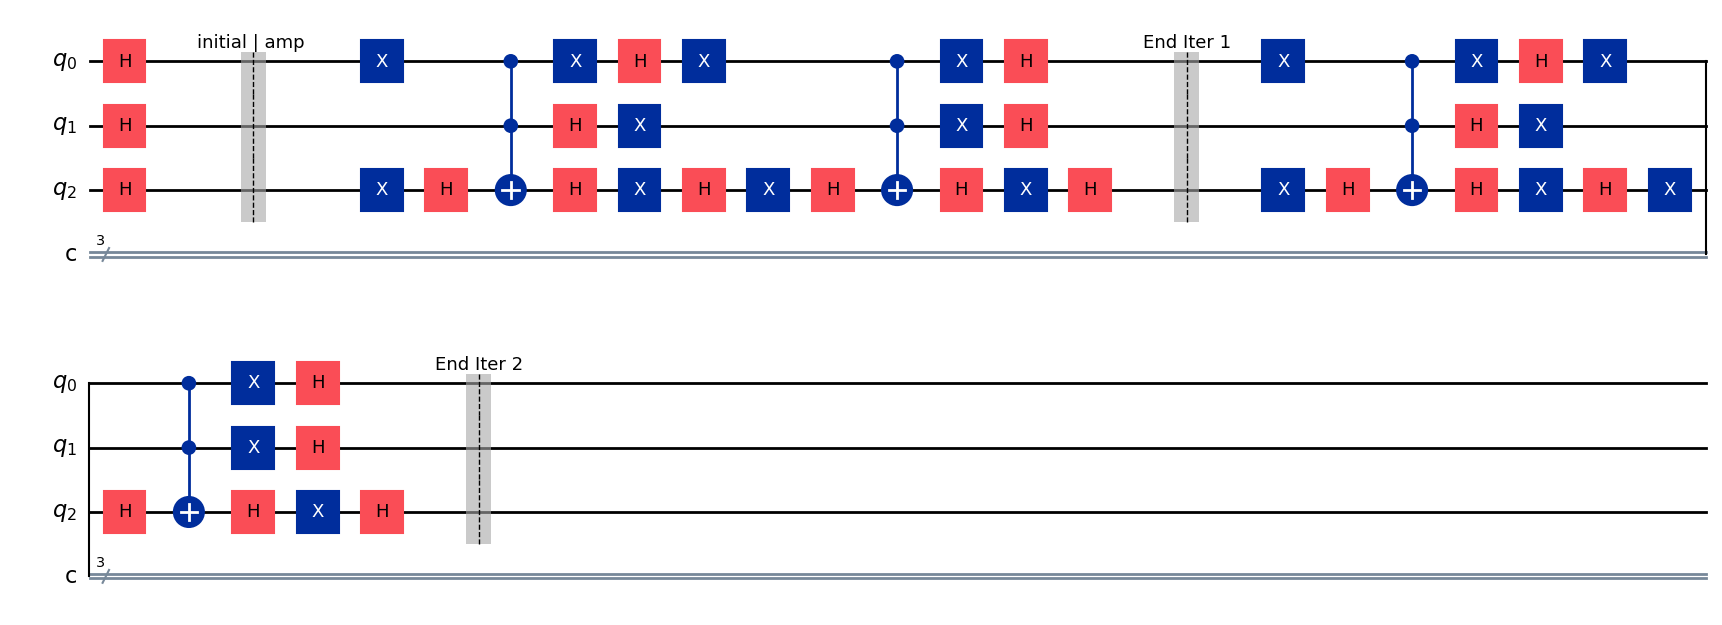

In [33]:
grover_diffuser(qc)
qc.barrier(label=f"End Iter {2}")
qc.draw(output="mpl", style="iqp")

In [35]:
s2_iter2_2 = (zero ^ zero ^ zero).evolve(Operator(qc))
s2_iter2_2.draw("latex")

<IPython.core.display.Latex object>

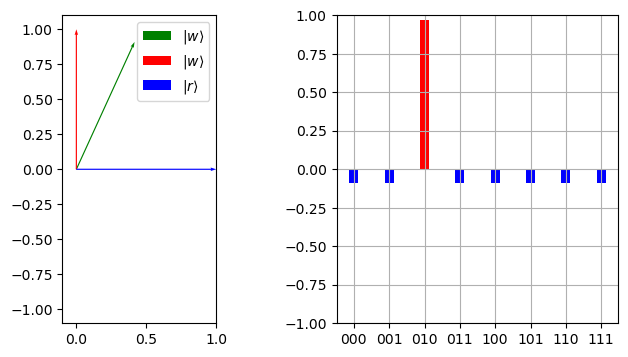

In [36]:
plot_angles_and_amplitudes(marked_bitstring, marked_qubit, s2_iter2_2)

### Step 3: Measure

Observe that the amplitude of the marked state $|010\rangle$ is $0.97$. This means the probability of measure it is about 95%. Thus the last step of Grover's is to measure and extract the state.

In [37]:
def grover_measure(qc):
    for n in range(qc.num_qubits):
        qc.measure(n, n)

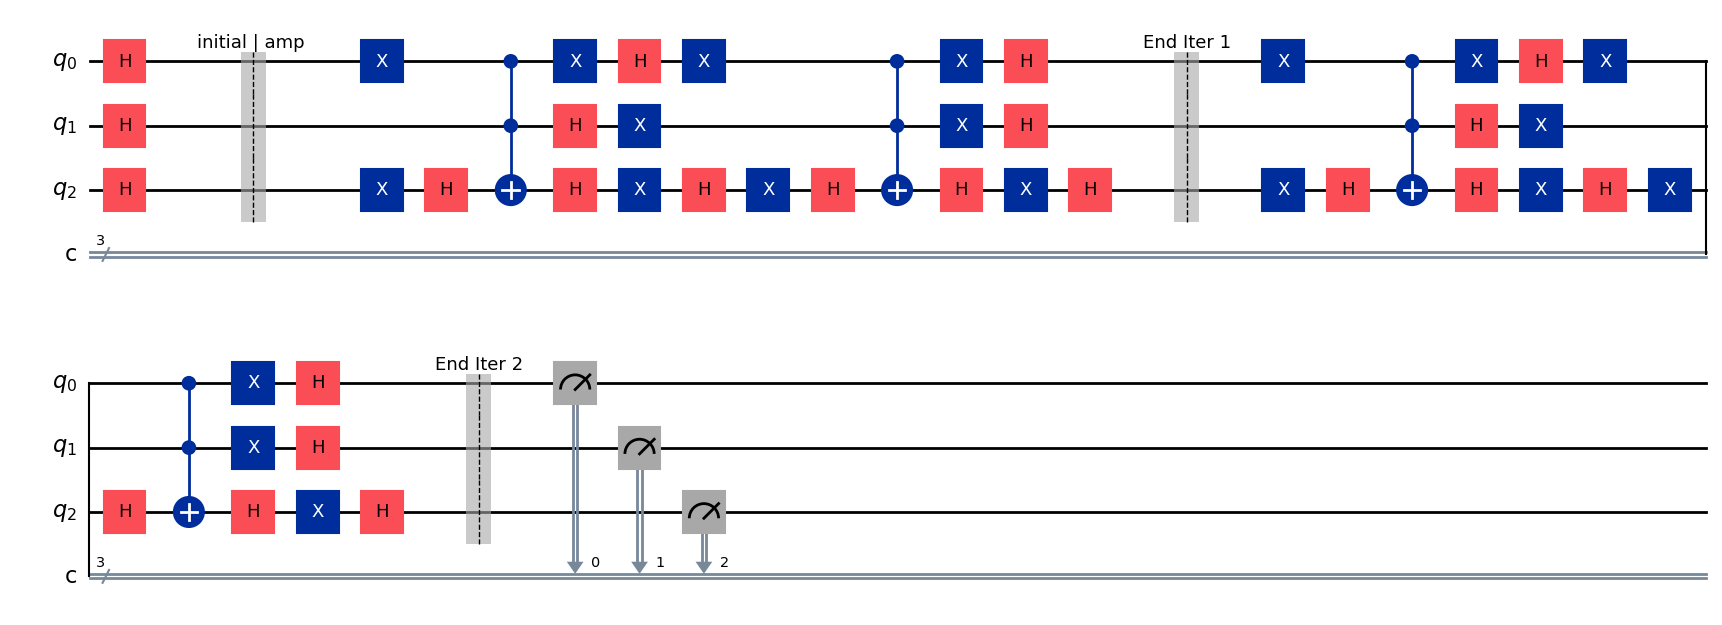

In [38]:
grover_measure(qc)
qc.draw(output="mpl", style="iqp")

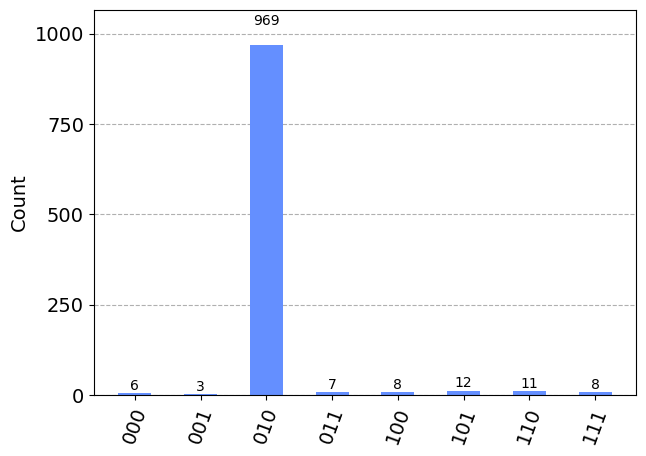

In [39]:
t_qc = transpile(qc, sim)
results = sim.run(t_qc, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

### Putting it all together

We can put this all together now.

In [40]:
def grovers(n_qubit: int, marked_bitstring: str) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubit, n_qubit)
    
    # Step 1: Superposition
    qc.h(range(n_qubit))
    
    # Step 2: Iterative Amplification
    num_iter = int(np.floor(np.pi / 4 * np.sqrt(2 ** n_qubit)))
    qc.barrier(label="Step 1|Step 2: Diffuser")
    for i in range(num_iter):
        # Step 2.1: Oracle
        grover_oracle(qc, marked_bitstring)
        qc.barrier(label=f"Oracle | Diffuser")
        
        # Step 2.2: Diffuser
        grover_diffuser(qc)
        qc.barrier(label=f"End Iter {i+1}")

    # Step 3: Read out results
    grover_measure(qc)
        
    return qc

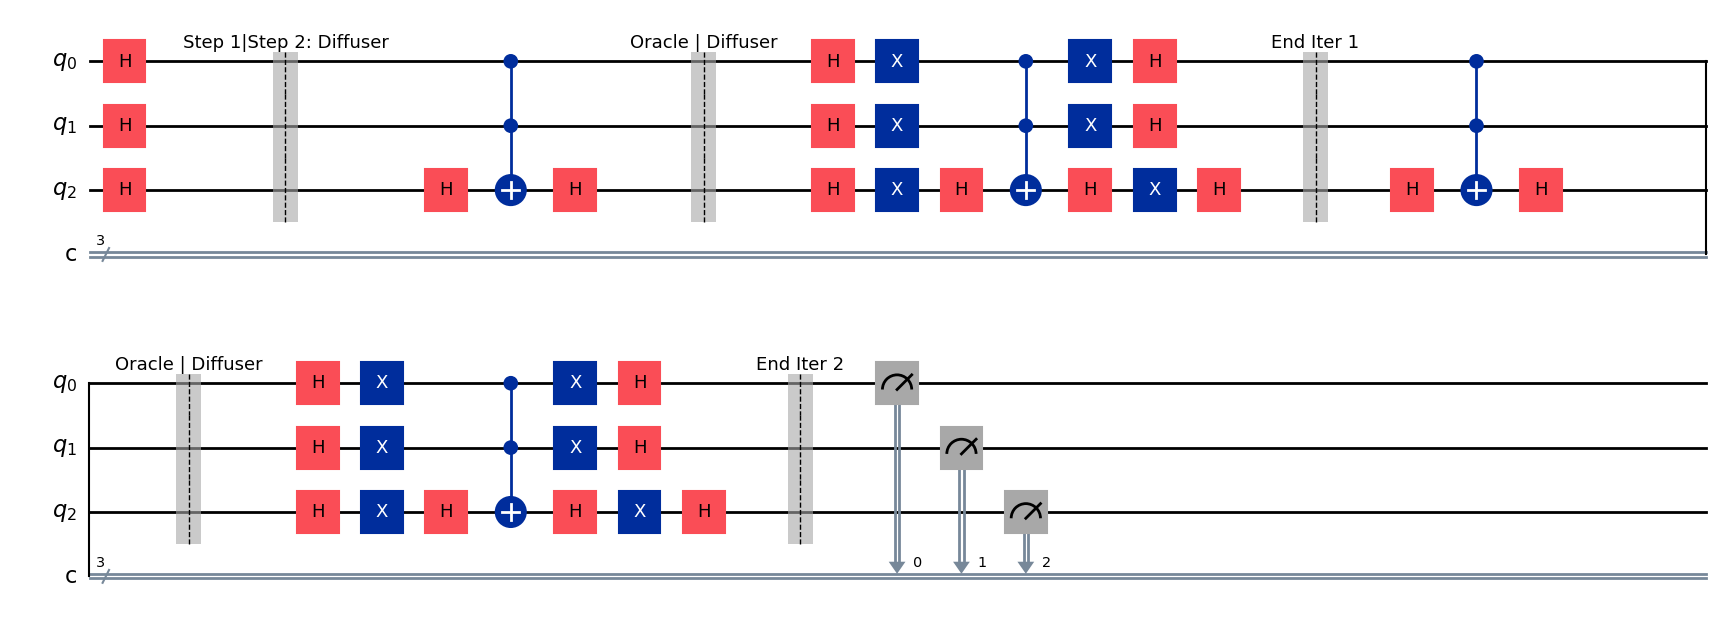

In [41]:
qc = grovers(3, "111")
qc.draw(output="mpl", style="iqp")

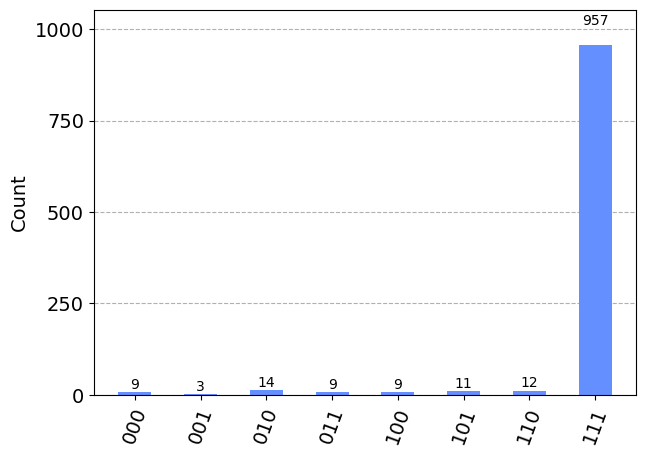

In [42]:
t_qc = transpile(qc, sim)
results = sim.run(t_qc, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

## Summary

1. We introduced Grover's search, a quantum algorithm for unstructured search.
2. Grover's search provides a quadratic speedup compared to classical search.